# Environment Set Up and Dependencies


In [ ]:

# Install dependencies
!pip install torch torchvision opencv-python matplotlib scikit-learn numpy requests



In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import requests
import zipfile
from io import BytesIO
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


# Datasets Preparation


In [ ]:

# Dataset Configuration
DATASET_URL = "https://datasets.cms.waikato.ac.nz/ufdl/data/102flowers/102flowers-subdir.zip"
DATA_DIR = "102flowers-subdir/subdir"
BATCH_SIZE = 32
IMG_SIZE = 224

# 1. Download if missing
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    print("Downloading dataset...")
    response = requests.get(DATASET_URL)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        z.extractall(DATA_DIR)
    print("Dataset extracted.")

# 2. FIND THE CLASS FOLDERS
print("Searching for class folders...")
dataset_root = None
max_subdirs = 0

for root, dirs, files in os.walk(DATA_DIR):
    if len(dirs) > max_subdirs:
        max_subdirs = len(dirs)
        dataset_root = root

print(f"Best candidate root: {dataset_root} with {max_subdirs} subdirectories.")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 3. Load ImageFolder
try:
    if dataset_root:
        dataset = torchvision.datasets.ImageFolder(root=dataset_root, transform=transform)
        print(f"Classes found: {len(dataset.classes)}")
        if len(dataset.classes) <= 1:
            print("ERROR: Only 1 or 0 classes found. The dataset structure is invalid for training!")

    # Split
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

except Exception as e:
    print(f"Data loading error: {e}")

Searching for class folders...
Best candidate root: 102flowers-subdir/subdir/subdir with 102 subdirectories.
Classes found: 102


# Model - CNN with CBAM


In [ ]:

# CBAM Components
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.ca(x)
        result = out * self.sa(out)
        return result

# 1. Standard CNN (Baseline)
class StandardCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(StandardCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # No CBAM

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # No CBAM

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # No CBAM

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 2. CNN with CBAM
class CNN_CBAM(nn.Module):
    def __init__(self, num_classes=102):
        super(CNN_CBAM, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.cbam1 = CBAM(64)

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.cbam2 = CBAM(128)

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.cbam3 = CBAM(256)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.cbam1(x)
        x = self.layer2(x)
        x = self.cbam2(x)
        x = self.layer3(x)
        x = self.cbam3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print("Initializing Models...")
model_baseline = StandardCNN(num_classes=102).to(device)
model_cbam = CNN_CBAM(num_classes=102).to(device)
print("Models Initialized: StandardCNN and CNN_CBAM")


Initializing Models...
Models Initialized: StandardCNN and CNN_CBAM


# Training


In [ ]:

criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=0.001)
optimizer_cbam = optim.Adam(model_cbam.parameters(), lr=0.001)

num_epochs = 20

def train_network(model, optimizer, name):
    print(f"\nTraining {name}...")
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print(f"{name} Training Finished")

# Train Both
train_network(model_baseline, optimizer_baseline, "Standard CNN")
train_network(model_cbam, optimizer_cbam, "CNN + CBAM")




Training Standard CNN...
Epoch [1/20], Loss: 3.7114
Epoch [2/20], Loss: 3.0233
Epoch [3/20], Loss: 2.7187
Epoch [4/20], Loss: 2.5120
Epoch [5/20], Loss: 2.3820
Epoch [6/20], Loss: 2.2642
Epoch [7/20], Loss: 2.1599
Epoch [8/20], Loss: 2.0658
Epoch [9/20], Loss: 1.9934
Epoch [10/20], Loss: 1.8992
Epoch [11/20], Loss: 1.8263
Epoch [12/20], Loss: 1.7600
Epoch [13/20], Loss: 1.7008
Epoch [14/20], Loss: 1.6429
Epoch [15/20], Loss: 1.5724
Epoch [16/20], Loss: 1.5398
Epoch [17/20], Loss: 1.4745
Epoch [18/20], Loss: 1.4472
Epoch [19/20], Loss: 1.3865
Epoch [20/20], Loss: 1.3538
Standard CNN Training Finished

Training CNN + CBAM...
Epoch [1/20], Loss: 3.6157
Epoch [2/20], Loss: 2.6661
Epoch [3/20], Loss: 2.2679
Epoch [4/20], Loss: 2.0193
Epoch [5/20], Loss: 1.8619
Epoch [6/20], Loss: 1.7171
Epoch [7/20], Loss: 1.5827
Epoch [8/20], Loss: 1.5004
Epoch [9/20], Loss: 1.3855
Epoch [10/20], Loss: 1.3015
Epoch [11/20], Loss: 1.2384
Epoch [12/20], Loss: 1.1868
Epoch [13/20], Loss: 1.0921
Epoch [14/20]

# Evaluation Metrics


In [ ]:

def evaluate_network(model, name):
    print(f"\n{'='*20}\nEvaluating {name}\n{'='*20}")
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    print(f"Test Score (Loss): {avg_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix Breakdown
    cm = confusion_matrix(all_labels, all_preds)
    TP = np.trace(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    print(f"Classification Summary:")
    print(f"True and Correct (True Positives): {TP}")
    print(f"True but Wrong (False Positives): {FP.sum()}")
    print(f"False but Wrong (False Negatives): {FN.sum()}")
    print(f"False but Correct (True Negatives): {TN.sum()}")
    print("-"*30)

# Evaluate Both
evaluate_network(model_baseline, "Standard CNN")
evaluate_network(model_cbam, "CNN + CBAM")




Evaluating Standard CNN
Test Score (Loss): 1.6018
Test Accuracy: 0.5684
Classification Summary:
True and Correct (True Positives): 931
True but Wrong (False Positives): 707
False but Wrong (False Negatives): 707
False but Correct (True Negatives): 70700
------------------------------

Evaluating CNN + CBAM
Test Score (Loss): 1.4225
Test Accuracy: 0.6392
Classification Summary:
True and Correct (True Positives): 1047
True but Wrong (False Positives): 591
False but Wrong (False Negatives): 591
False but Correct (True Negatives): 59100
------------------------------


# Sample Test with Images (Visualizations)


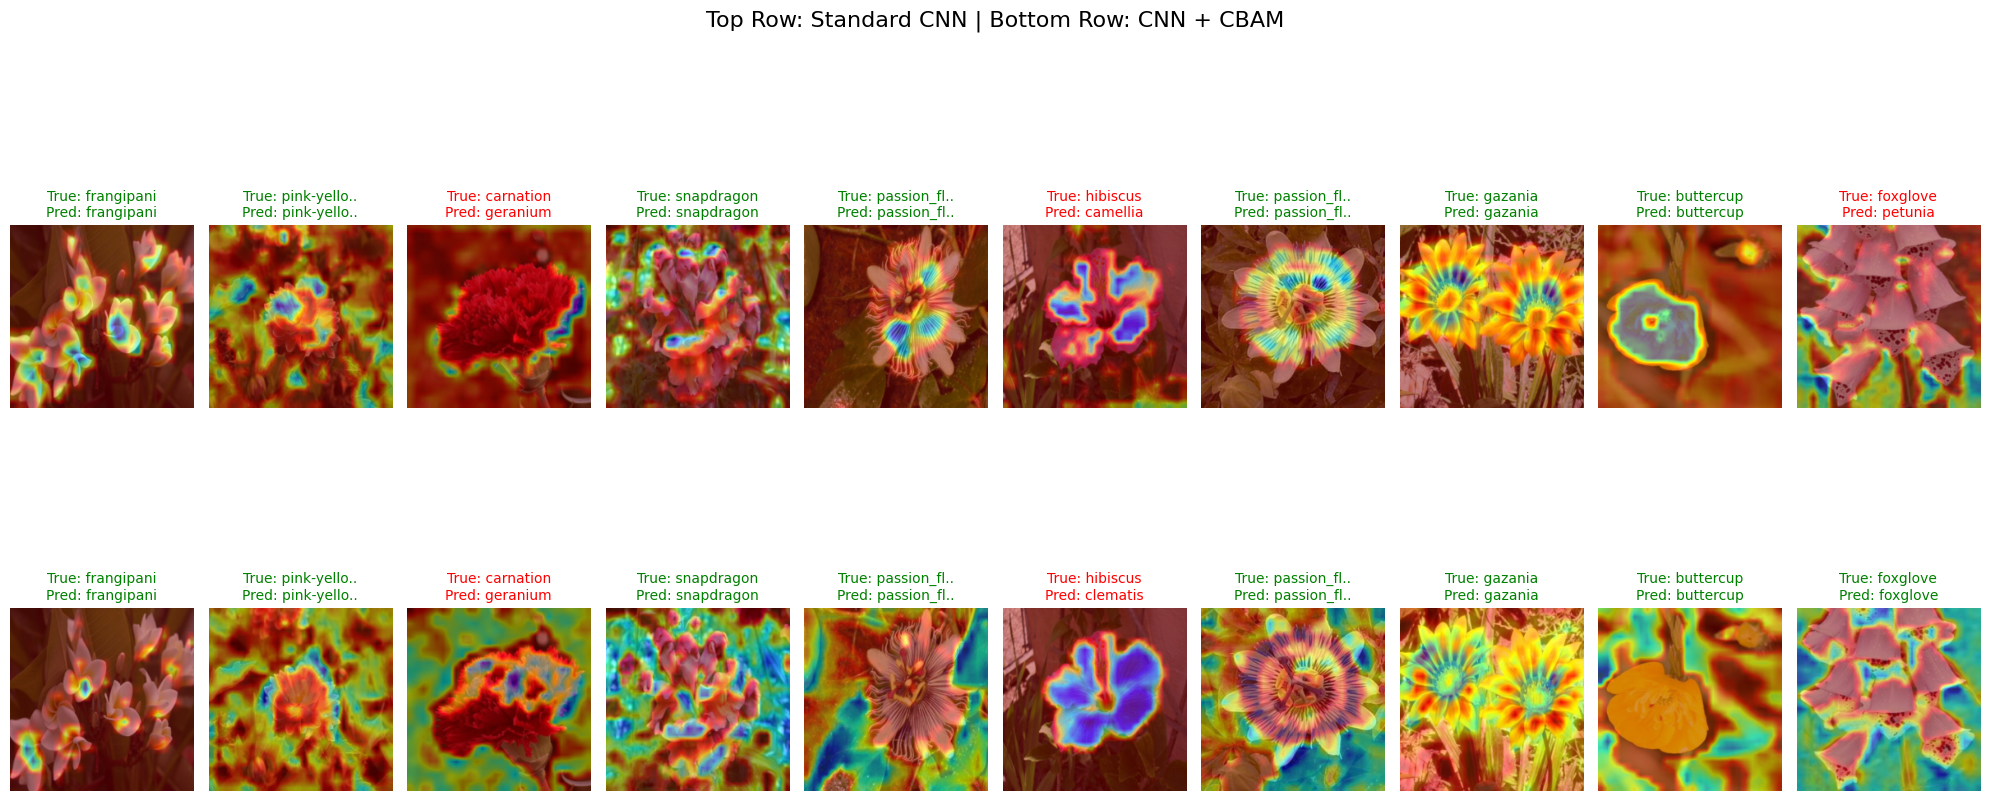

In [ ]:

# Function to generate Grad-CAM or Attention Maps
def visualize_attention(model, img_tensor, original_img, target_layer):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks on the specific target layer instance
    handle_bw = target_layer.register_full_backward_hook(backward_hook)
    handle_fw = target_layer.register_forward_hook(forward_hook)

    # Inference
    img_tensor = img_tensor.unsqueeze(0).to(device)
    # Temporarily allow grad for visualization
    with torch.enable_grad():
        output = model(img_tensor)
        idx = torch.argmax(output)

        # Backward
        model.zero_grad()
        output[0, idx].backward()

    # Grad-CAM Logic
    if len(gradients) > 0 and len(activations) > 0:
        grads = gradients[0].cpu().data.numpy()[0]
        fmap = activations[0].cpu().data.numpy()[0]

        weights = np.mean(grads, axis=(1, 2))
        cam = np.zeros(fmap.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * fmap[i, :, :]

        cam = np.maximum(cam, 0)
        if cam.max() > 0:
            cam = cam / cam.max()
        cam = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))

        # Heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        result = heatmap + np.float32(original_img)
        result = result / np.max(result)
    else:
        result = original_img # Fallback

    handle_bw.remove()
    handle_fw.remove()

    return result, idx.item()

# Test on a few images
num_samples = 10
indices = np.random.choice(len(test_dataset), num_samples, replace=False)
class_names = dataset.classes if hasattr(dataset, 'classes') else [str(i) for i in range(102)]

plt.figure(figsize=(20, 10))
plt.suptitle("Top Row: Standard CNN | Bottom Row: CNN + CBAM", fontsize=16)

for i, idx in enumerate(indices):
    img_tensor, label_idx = test_dataset[idx]

    # Denormalize for display
    inv_normalize = transforms.Normalize(
       mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
       std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_disp = inv_normalize(img_tensor).permute(1, 2, 0).numpy()
    img_disp = np.clip(img_disp, 0, 1)

    # --- 1. Standard CNN ---
    img_tensor.requires_grad = True
    # Hook layer3 of average pool input
    res_base, pred_base = visualize_attention(model_baseline, img_tensor, img_disp, model_baseline.layer3)

    plt.subplot(2, num_samples, i+1)
    true_label = class_names[label_idx]
    # Truncate
    true_label_short = true_label if len(true_label) < 12 else true_label[:10] + ".."
    pred_label_base = class_names[pred_base]
    pred_label_base_short = pred_label_base if len(pred_label_base) < 12 else pred_label_base[:10] + ".."

    col = 'green' if label_idx == pred_base else 'red'
    plt.title(f"True: {true_label_short}\nPred: {pred_label_base_short}", color=col, fontsize=10)
    plt.imshow(res_base)
    plt.axis('off')

    # --- 2. CBAM ---
    img_tensor.requires_grad = True
    res_cbam, pred_cbam = visualize_attention(model_cbam, img_tensor, img_disp, model_cbam.layer3)

    plt.subplot(2, num_samples, i+1+num_samples)
    pred_label_cbam = class_names[pred_cbam]
    pred_label_cbam_short = pred_label_cbam if len(pred_label_cbam) < 12 else pred_label_cbam[:10] + ".."
    col = 'green' if label_idx == pred_cbam else 'red'
    plt.title(f"True: {true_label_short}\nPred: {pred_label_cbam_short}", color=col, fontsize=10)
    plt.imshow(res_cbam)
    plt.axis('off')

plt.tight_layout()
plt.show()

